In [1]:
# Standard tools
import sys
import numpy as np


# Import I/O for timedata
try:
    sys.path.append('../../../../globals/python/timedata/')
    import timedata as td
except:
    print("Global repo non found")

# Import geometry tools
sys.path.append('../../../tools/preprocess/assembly/')
import meshtools as mt
import example_grid

# Import geometry tools
sys.path.append('../')
import dmk_p1p0 
sys.path.append('../../../../geometry/build/python/fortran_python_interface/')
from geometry import (get_boundary_nodes_from_topol)

# Import dmk tools
sys.path.append('../')
import dmk_p1p0 
sys.path.append('../../../build/python/fortran_python_interface/')
from dmk import (Dmkcontrols,  # controls for dmk simulations)
                 Timefunctionals # information of time/algorithm evolution
                )
# Import plot tools
import matplotlib.pyplot as plt
import matplotlib.tri as mtri



/home/fh/scratch/muffe_p1p0/globals/python_timedata
/home/fh/scratch/muffe_p1p0/python/dmk_p1p0/work_in_progress
/home/fh/scratch/muffe_p1p0/tools/preprocess/assembly
/home/fh/scratch/muffe_p1p0/build/python/fortran_python_interface


Define mesh for spatial disctetization.

Build the "coord" and "topol" numpy arrays describing coordinate and topology of the mesh.

In [2]:
# set mesh size 
ndiv=16
length=1.0/float(ndiv)

# set grid example
flag_grid='hole_square'

# build grid using prebuild examples 
points, vertices, coord,topol,element_attributes = example_grid.example_grid(flag_grid,length)
ncell=len(topol)
nnode=len(coord)

302
1160


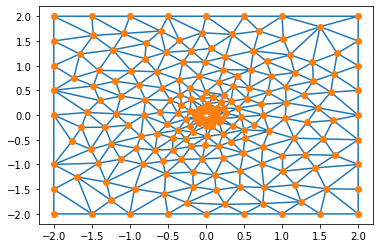

In [16]:
# plot the grid
triang = mtri.Triangulation(coord.transpose()[0,:], coord.transpose()[1,:], topol)
plt.triplot(triang, marker="o")
plt.show()

In [4]:
#Save the grid to file
mt.write_grid(coord,topol,'grid_hole.dat','dat')

In [49]:
nboundarynode=np.int32(0.0)#np.zeros((1,), dtype=np.int32)
nboundarynode=np.zeros((1,), dtype=np.int32)
#print(nboundarynode.dtype,ncell.dtype)
boundarynodes=np.zeros((nnode,), dtype=np.int32)
print(nboundarynode)
# Handle different shape and pyhton ordering 
if ( topol.shape[0] > topol.shape[1]  ):
    topolfortran=topol.transpose()
else: 
    topolfortran=topol
if ( np.amin(topolfortran) == 0 ):
    topolfortran=topolfortran+1
coordfortran=coord.transpose()

info=0
get_boundary_nodes_from_topol(0, 3, nnode, ncell, topolfortran,coordfortran, nboundarynode, info, boundarynodes)
nboundarynode=nboundarynode[0]
print(nboundarynode)
boundarynodes=boundarynodes[0:nboundarynode]-1
print(nboundarynode,len(boundarynodes))



[0]
332
332 332


In [50]:
# set Direchlet nodes
dirnodes=[]
dirvalues=[]
for i in np.arange(nboundarynode):
    inode=boundarynodes[i]
    
    r=np.linalg.norm(coord[inode,:])
    if (r<0.3):
        print(inode,coord[inode,:],r)
        dirnodes.append(inode)
        dirvalues.append(r)
    
dirnodes=np.array(dirnodes)
print(dirvalues)
print(dirnodes.dtype)

4 [0.1 0.  0. ] 0.1
5 [0.09997836 0.00208037 0.        ] 0.1
6 [0.09991344 0.00415985 0.        ] 0.1
7 [0.09980528 0.00623752 0.        ] 0.1
8 [0.09965391 0.0083125  0.        ] 0.09999999999999999
9 [0.09945941 0.01038387 0.        ] 0.1
10 [0.09922187 0.01245075 0.        ] 0.1
11 [0.09894137 0.01451225 0.        ] 0.1
12 [0.09861805 0.01656746 0.        ] 0.1
13 [0.09825204 0.0186155  0.        ] 0.1
14 [0.0978435  0.02065548 0.        ] 0.09999999999999999
15 [0.09739262 0.02268652 0.        ] 0.10000000000000002
16 [0.09689957 0.02470774 0.        ] 0.1
17 [0.09636459 0.02671827 0.        ] 0.1
18 [0.09578789 0.02871723 0.        ] 0.1
19 [0.09516974 0.03070376 0.        ] 0.1
20 [0.09451039 0.03267701 0.        ] 0.1
21 [0.09381013 0.0346361  0.        ] 0.1
22 [0.09306927 0.03658021 0.        ] 0.1
23 [0.09228812 0.03850848 0.        ] 0.1
24 [0.09146702 0.04042009 0.        ] 0.1
25 [0.09060634 0.0423142  0.        ] 0.1
26 [0.08970644 0.04418999 0.        ] 0.1
27 [0.0887677

In [20]:
print(coord[boundarynodes[1:13],:])

[[ 2.          2.          0.        ]
 [-2.          2.          0.        ]
 [ 0.1         0.          0.        ]
 [ 0.09997836  0.00208037  0.        ]
 [ 0.09991344  0.00415985  0.        ]
 [ 0.09980528  0.00623752  0.        ]
 [ 0.09965391  0.0083125   0.        ]
 [ 0.09945941  0.01038387  0.        ]
 [ 0.09922187  0.01245075  0.        ]
 [ 0.09894137  0.01451225  0.        ]
 [ 0.09861805  0.01656746  0.        ]
 [ 0.09825204  0.0186155   0.        ]]


Define source (initial configuration) and sink (final configuration) functions $f^+$ and $f^-$. Forcing term $f=f^+-f^-$.

For the functions considered there exists and explicit solutions of the Monge-Kantorovich equations
$$
\nabla \cdot ( \mu^*(x) \nabla u^*(x) )= f(x) \\
|\nabla u(x)|\leq 1 \\
|\nabla u(x)|=1 \mbox{\ where \ } \mu^*(x)>0 \\
$$

We create piecewise constant rapresentations of $f,f^+,f-$ and $\mu^*$, evaluating the function on cell centroids.

In [7]:
# define source and sink functions, value of grid centroids
def source(coord):
    x=coord[0]; y=coord[1]
    if ((x >= 1.0/8.0) and (x<=3.0/8.0) and
        (y >= 1.0/4.0) and (y<=3.0/4.0) ) :
        fvalue=2.0
    else:
        fvalue=0.0
        
    return fvalue;

def sink(coord):
    x=coord[0]; y=coord[1]    
    if ((x >= 5.0/8.0) and (x<=7.0/8.0) and
        (y >= 1.0/4.0) and (y<=3.0/4.0) ) :
        fvalue=2.0
    else:
        fvalue=0.0       
    return fvalue;
# For this case there exists an explicit solution of the Monge-Kantorivich equations:
# The optimal transport density:
def optimal_transport_density(coord):
    x=coord[0]; y=coord[1];
    if ((x >= 1.0/8.0) and (x<=3.0/8.0) and
        (y >= 1.0/4.0) and (y<=3.0/4.0) ) :
        fvalue=(x-1.0/8.0)*2.0
    elif ((x >= 3.0/8.0) and (x<=5.0/8.0) and
          (y >= 1.0/4.0) and (y<=3.0/4.0) ) :
        fvalue=(3.0/8.0-1.0/8.0)*2.0 
    elif ((x >= 5.0/8.0) and (x<=7.0/8.0) and
          (y >= 1.0/4.0) and (y<=3.0/4.0) ) :
        fvalue=(7.0/8.0-x)*2.0
    else:
        fvalue=0.0
    return fvalue;
# and the Kantorovich potential
def kantorovich_potenial(coord):
    x=coord[0];        
    return -x;

# compute functions on cell centroids

bar_cell=mt.make_bar(coord,topol).transpose()
source_cell=np.zeros([ncell]); sink_cell=np.zeros([ncell]); opttdens_cell=np.zeros([ncell])
for i in range(ncell):
    source_cell[i] = source(bar_cell[:,i])
    sink_cell[i]   = sink(bar_cell[:,i])
    opttdens_cell[i] = optimal_transport_density(bar_cell[:,i])
forcing_cell=source_cell-sink_cell

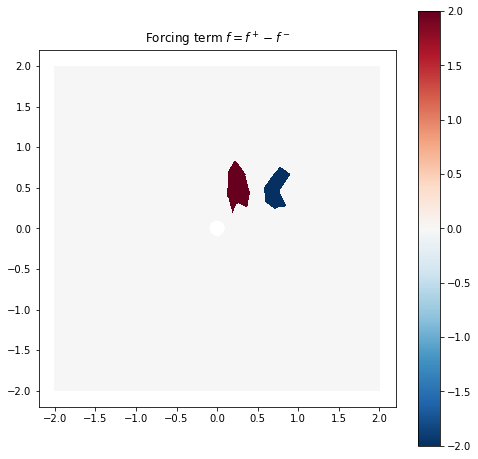

In [8]:
import matplotlib.tri as mtri
# plot forcing term
triang = mtri.Triangulation(coord.transpose()[0,:], coord.transpose()[1,:], topol)
fig1, ax1 = plt.subplots(figsize=(8, 8)); ax1.set_aspect('equal')
tpc = ax1.tripcolor(triang, forcing_cell , cmap='RdBu_r')
fig1.colorbar(tpc)
ax1.set_title('Forcing term $f=f^+-f^-$')
plt.show()


In [9]:
# init and set controls
ctrl = Dmkcontrols.DmkCtrl()
Dmkcontrols.get_from_file(ctrl,'dmk.ctrl')
ctrl.fn_tdens='tdens.dat'
ctrl.fn_pot='pot.dat'
ctrl.fn_statistics='dmk.log'
#ctrl.lun_statistics=0

In [ ]:
[info,opttdens,optpot,tolop_subgrid,coord_subgrid,timefun] = dmk_p1p0.solve_MinFluxProblem(topol,
                                                                                              coord,
                                                                                              forcing_cell,
                                                                                           pflux=1.3,
                                                                                              tolerance=1e-5,
                                                                                              ctrl=ctrl)
if (info==0): print('Convergence achieved')

In [ ]:
import matplotlib.tri as mtri
# plot forcing term
triang = mtri.Triangulation(coord.transpose()[0,:], coord.transpose()[1,:], topol)
fig1, ax1 = plt.subplots(figsize=(8, 8)); ax1.set_aspect('equal')
tpc = ax1.tripcolor(triang, np.log(opttdens) , cmap='RdBu_r')
fig1.colorbar(tpc)
ax1.set_title('Optimal Transport Density $\mu^*$')
plt.show()

In [ ]:
# plot convergence toward steady state
time      = np.array(timefun.time[0:timefun.last_time_iteration]);
cpu_time  = np.array(timefun.cpu_time[0:timefun.last_time_iteration])
var_tdens = np.array(timefun.var_tdens[1:timefun.last_time_iteration])
wass1     = np.array(timefun.lyapunov[1:timefun.last_time_iteration])
wass1[:]=wass1[:]-1.0/8.0

plt.figure(1)
plt.subplot(211)
plt.yscale('log')
plt.ylabel('var($\mu$)')
plt.xlabel('time t')
plt.grid(True)
plt.plot(time[1:], wass1, 'bo--')

plt.subplot(212)
plt.yscale('log')
plt.ylabel('var($\mu$)')
plt.xlabel('CPU time (s)')
plt.grid(True)
plt.plot(cpu_time[1:], wass1, 'ro--')
plt.show()